## 分析A/B测试结果


## 目录
- [简介](#intro)
- [I - 概率](#probability)
- [II - A/B 测试](#ab_test)
- [III - 回归](#regression)


<a id='intro'></a>
### 简介

通常情况下，A/B 测试由数据分析师和数据科学家来完成。如果你在一些实践工作中遇到过这方面的问题，那学习起来就会更加游刃有余。

对于这个项目，你将要了解的是电子商务网站运行的 A/B 测试的结果。你的目标是通过这个 notebook 来帮助公司弄清楚他们是否应该使用新的页面，保留旧的页面，或者应该将测试时间延长，之后再做出决定。


<a id='probability'></a>
#### I - 概率

In [86]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` 现在，导入 `ab_data.csv` 数据，并将其存储在 `df` 中。  **使用你的 dataframe 来回答课堂测试 1 中的问题。**

a. 导入数据集，并在这里查看前几行：

In [87]:
df = pd.read_csv('ab_data.csv')
df.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


b. 使用下面的单元格来查找数据集中的行数。

In [88]:
df.info(),df.converted.unique(),df.landing_page.unique(),df.group.unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


(None,
 array([0, 1], dtype=int64),
 array(['old_page', 'new_page'], dtype=object),
 array(['control', 'treatment'], dtype=object))

c. 数据集中独立用户的数量。

In [89]:
df.user_id.nunique()

# 数据集中独立用户的数量

290584

d. 用户转化的比例。

In [90]:
df.query('converted == 1').user_id.size / df.user_id.size

## 计算用户转换的比例

0.11965919355605512

e.  `new_page` 与 `treatment` 不一致的次数。

In [91]:
df.query('landing_page == "old_page" and group == "treatment"').user_id.size
## 登录旧网页的实验组

1965

In [92]:
df.query('landing_page == "new_page" and group == "control"').user_id.nunique()
## 登录新网页的对照组

1928


f. 是否有任何行存在缺失值？

In [93]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` 对于 **treatment** 不与 **new_page** 一致的行或 **control** 不与 **old_page** 一致的行，我们不能确定该行是否真正接收到了新的或旧的页面。我们应该如何处理这些行？在课堂中的 **测试 2** 中，给出你的答案。  

a. 现在，使用测试题的答案创建一个符合测试规格要求的新数据集。将新 dataframe 存储在 **df2** 中。

In [94]:
df_a = df.query('landing_page == "old_page" and group == "control"')
df_b = df.query('landing_page == "new_page" and group == "treatment"')
df2 = df_a.append(df_b , ignore_index=True)

In [95]:
df2.info()
df2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290585 entries, 0 to 290584
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.1+ MB


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,864975,2017-01-21 01:52:26.210827,control,old_page,1
3,936923,2017-01-10 15:20:49.083499,control,old_page,0
4,719014,2017-01-17 01:48:29.539573,control,old_page,0


In [96]:
## 确认所有的无效数据都已经被移除
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` 

a.  **df2** 中有多少唯一的 **user_id**?

In [85]:
df2.user_id.nunique()

290584

b.  **df2** 中有一个重复的 **user_id** 。它是什么？ 

In [26]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
146678,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. 这个重复的  **user_id** 的行信息是什么？

In [27]:
df2.iloc[146678]

user_id                             773192
timestamp       2017-01-14 02:55:59.590927
group                            treatment
landing_page                      new_page
converted                                0
Name: 146678, dtype: object

d. 删除 **一个** 含有重复的 **user_id** 的行， 但使你的 dataframe 为 **df2**。

In [28]:
df2 = df2.drop(146678)
df2 = df2.reset_index(drop=True)
df2.iloc[146678]

user_id                             884145
timestamp       2017-01-09 15:45:38.457508
group                            treatment
landing_page                      new_page
converted                                0
Name: 146678, dtype: object

`4.` 在下面的单元格中，使用 **df2** 来回答与课堂中的 **测试 4** 相关的测试题目。

a. 不管它们收到什么页面，单个用户的转化率是多少？


In [29]:
df2.converted.mean()

0.11959708724499628

b. 假定一个用户处于 `control` 组中，他的转化率是多少？

In [30]:
df2.query('group == "control"').converted.mean()

0.1203863045004612

c. 假定一个用户处于 `treatment` 组中，他的转化率是多少？


In [31]:
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

d. 一个用户收到新页面的概率是多少？


In [32]:
df2.query('landing_page == "new_page"').user_id.size / df2.user_id.size

0.5000619442226688

In [33]:
df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()

-0.0015782389853555567

我们已知，总体的转变概率是11.96%,在对照组中是12.04% ，在实验组中为11.88%

<a id='ab_test'></a>
### II - A/B 测试

请注意，由于与每个事件相关的时间戳，你可以在进行每次观察时连续运行假设检验。  

然而，问题的难点在于，一个页面被认为比另一页页面的效果好得多的时候你就要停止检验吗？还是需要在一定时间内持续发生？你需要将检验运行多长时间来决定哪个页面比另一个页面更好？

一般情况下，这些问题是A / B测试中最难的部分。如果你对下面提到的一些知识点比较生疏，请先回顾课程中的“描述统计学”部分的内容。

`1.` 现在，你要考虑的是，你需要根据提供的所有数据做出决定。如果你想假定旧的页面效果更好，除非新的页面在类型I错误率为5％的情况下才能证明效果更好，那么，你的零假设和备择假设是什么？ 你可以根据单词或旧页面与新页面的转化率 **$p_{old}$** 与 **$p_{new}$** 来陈述你的假设。

**在这里给出你的答案。**

$H_0: p_{new} - p_{old} \leq 0$

$H_1: p_{new} - p_{old} > 0$

`2.` 假定在零假设中，不管是新页面还是旧页面， $p_{new}$ and $p_{old}$ 都具有等于 **转化** 成功率的“真”成功率，也就是说，  $p_{new}$ 与 $p_{old}$ 是相等的。此外，假设它们都等于**ab_data.csv** 中的 **转化** 率，新旧页面都是如此。  <br><br>

每个页面的样本大小要与 **ab_data.csv** 中的页面大小相同。  <br><br>

执行两次页面之间 **转化** 差异的抽样分布，计算零假设中10000次迭代计算的估计值。  <br><br>


a. 在零假设中，$p_{new}$ 的 **convert rate（转化率）** 是多少？


In [97]:
## 在零假设下我们得到P(old)与P(new)相等
df2.converted.mean()

0.11959667567149027

b. 在零假设中， $p_{old}$  的 **convert rate（转化率）** 是多少？ <br><br>

In [98]:
df2.converted.mean()

0.11959667567149027

c.  $n_{new}$ 是多少？

In [36]:
df2.query('group == "treatment"').user_id.size #145310 147276

## 计算Nnew的数量大小

145310

d.  $n_{old}$?是多少？

In [37]:
df2.query('group == "control"').user_id.size #145274 147202

## 计算Nold的数量大小

145274

e. 在零假设中，使用 $p_{new}$ 转化率模拟 $n_{new}$ 交易，并将这些 $n_{new}$ 1's 与 0's 存储在 **new_page_converted** 中。

In [61]:
convert_rate = df2.query('converted == 1').shape[0] / df2.shape[0] ; convert_rate
## convert_rate 指的是改变的数量除以总的数量

0.11959708724499628

In [43]:
new_page_converted = np.random.choice([0,1], size=145310, p=[1-0.1196, 0.1196]);new_page_converted

array([1, 0, 0, ..., 0, 0, 0])

f. 在零假设中，使用 $p_{old}$ 转化率模拟 $n_{old}$ 交易，并将这些  $n_{old}$ 1's 与 0's 存储在 **old_page_converted** 中。

In [63]:
old_page_converted = np.random.choice([0,1], size=145274,replace = True, p=[1-0.1196, 0.1196]); old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. 在 (e) 与 (f)中找到 $p_{new}$ - $p_{old}$ 模拟值。

In [64]:
new_page_converted.mean() - old_page_converted.mean()

-0.000814143409405485

h. 使用**a. 到 g. ** 中的计算方法来模拟 10,000个 $p_{new}$ - $p_{old}$ 值，并将这 10,000 个值存储在 **p_diffs** 中。

In [65]:
p_diffs = []

for i in range(10000):
    control_df = np.random.choice([0,1],size=145274,p=[1-0.1196,0.1196])
    treat_df = np.random.choice([0,1],size = 145310,p=[1-0.1196,0.1196])
    p_old = control_df.mean()
    p_new = treat_df.mean()
    p_diffs.append(p_new - p_old)
    
p_diffs = np.array(p_diffs)

i. 绘制一个 **p_diffs** 直方图。这个直方图看起来像你所期望的吗？

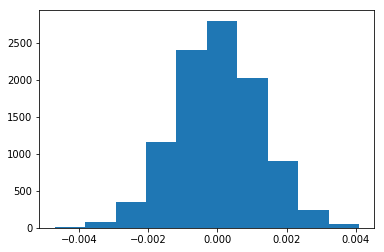

In [99]:
plt.hist(p_diffs)
plt.show()

j.  在**p_diffs**列表的数值中，有多大比例大于 **ab_data.csv** 中观察到的实际差值？

In [100]:
(p_diffs > -0.001576).mean()

0.9074

k.我们刚刚计算了p值，p值表现了我们接受零假设的概率。我们不能拒绝零假设，因为(0.9>0.05)
这意味着差异非常不显著，新页面不会比旧页面更好。

l. 我们也可以使用一个内置程序 （built-in）来实现类似的结果。尽管使用内置程序可能更易于编写代码，但上面的内容是对正确思考统计显著性至关重要的思想的一个预排。填写下面的内容来计算每个页面的转化次数，以及每个页面的访问人数。使用 `n_old` 与 `n_new` 分别引证与旧页面和新页面关联的行数。

In [70]:
import statsmodels.api as sm

In [71]:
convert_old = df2.query('group == "control" and converted == 1').user_id.size
convert_new = df2.query('group == "treatment" and converted == 1').user_id.size
n_old = df2.query('group == "control"').user_id.size
n_new = df2.query('group == "treatment"').user_id.size
convert_old,convert_new,n_old,n_new

(17489, 17264, 145274, 145310)

m. 现在使用 `stats.proportions_ztest` 来计算你的检验统计量与 p-值。[这里](http://knowledgetack.com/python/statsmodels/proportions_ztest/) 是使用内置程序的一个有用链接。

In [72]:
z_score , p_value = sm.stats.proportions_ztest([convert_old , convert_new],[n_old,n_new])
z_score,p_value

(1.3109241984234394, 0.18988337448195103)

In [73]:
from scipy.stats import norm

norm.cdf(1.3109241984234394),norm.ppf(1-(0.05))

(0.9050583127590245, 1.6448536269514722)

n. 根据上题算出的 z-score 和 p-value，我们认为新旧页面的转化率是否有区别？它们与 **j.** 与 **k.** 中的结果一致吗？

**在这里给出你的答案。**

z-score并没有超过1.6448536269514722,p值是0.905，我们不能拒绝零假设，这两个比例近乎一致

<a id='regression'></a>
### III - 回归分析法之一

`1.` 在最后一部分中，你会看到，你在之前的A / B测试中获得的结果也可以通过执行回归来获取。<br><br>

a. 既然每行的值是转化或不转化，那么在这种情况下，我们应该执行哪种类型的回归？

**在这里给出你的答案。**

b. 目标是使用 **statsmodels** 来拟合你在 **a.** 中指定的回归模型，以查看用户收到的不同页面是否存在显著的转化差异。但是，首先，你需要为这个截距创建一个列（ 原文：column） ，并为每个用户收到的页面创建一个虚拟变量列。添加一个 **截距** 列，一个 **ab_page** 列，当用户接收 **treatment** 时为1， **control** 时为0。


c. 使用 **statsmodels** 导入你的回归模型。 实例化该模型，并使用你在 **b.** 中创建的2个列来拟合该模型，用来预测一个用户是否会发生转化。

d. 请在下方提供你的模型摘要，并根据需要使用它来回答下面的问题。

e. 与 **ab_page** 关联的 p-值是多少？ 为什么它与你在 **II** 中发现的结果不同？<br><br>  **提示**: 与你的回归模型相关的零假设与备择假设分别是什么？它们如何与 **Part II** 中的零假设和备择假设做比较？

**在这里给出你的答案。**



f. 现在，你一定在考虑其他可能影响用户是否发生转化的因素。讨论为什么考虑将其他因素添加到回归模型中是一个不错的主意。在回归模型中添加附加项有什么弊端吗？

**在这里给出你的答案。**

g. 现在，除了测试不同页面的转化率是否会发生变化之外，还要根据用户居住的国家或地区添加一个 effect 项。你需要导入 **countries.csv** 数据集，并将数据集合并在适当的行上。 [这里](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) 是链接表格的文档。 

这个国家项对转化有影响吗？不要忘记为这些国家的列创建虚拟变量—— **提示: 你将需要为这三个虚拟变量增加两列。** 提供统计输出，并书面回答这个问题。

h. 虽然你现在已经查看了国家与页面在转化率上的个体性因素，但现在我们要查看页面与国家/地区之间的相互作用，测试其是否会对转化产生重大影响。创建必要的附加列，并拟合一个新的模型。  

提供你的摘要结果，以及根据结果得出的结论。

**提示：页面与国家/地区的相互作用**
```
df3['new_CA'] = df3['new_page'] * df3['CA']
df3['new_UK'] = df3['new_page'] * df3['UK']
```